In [182]:
%load_ext autoreload
%autoreload 2


from ff_energy.ffe.slurm import SlurmJobHandler
from pathlib import Path
import pandas as pd
import jax.numpy as jnp
import itertools as it
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import patchworklib as pw


from ff_energy.ffe.potential import (
    LJ,
    DE,
)

from ff_energy.ffe.ff import FF
from ff_energy.ffe.constants import FFEPATH, NB_PATH
from ff_energy.plotting.ffe_plots import plot_energy_MSE, plot_ff_fit

from ff_energy.plotting.plotting import set_style, patchwork_grid, save_fig


from ff_energy.plotting.fit_results import (
    residuals_plot, simple_residuals_plot, residuals_from_keys
)

from ff_energy.logs.logging import hide_logs

from ff_energy.ffe.potential import LJ, LJ_bound, DE


hide_logs()


import scienceplots
set_style(no_latex=True)

# sns.set_style()
# plt.style.use(["science", "no-latex"])


from ff_energy.ffe.ff_fit import (
    load_ff,
    fit_func,
    fit_repeat,
)

from ff_energy.utils.ffe_utils import pickle_output, read_from_pickle, str2int, PKL_PATH
from ff_energy.utils.json_utils import load_json

from ff_energy.ffe.structure import atom_key_pairs

from ff_energy.logs.logging import logger
logger.disabled = True


structure_data = {
    "dcm": "",
    "water_cluster": PKL_PATH / "20230823_water_clusters.pkl.pkl",
}

intE_label = "PBE0 Energy [kcal/mol]"
FFintE_label = "FF Energy [kcal/mol]"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#  Start

In [183]:
mikes_data_path = NB_PATH / "working" / "mikedata" / "mike_fig_data"

In [184]:
folders = list(mikes_data_path.glob("*"))

In [185]:
data = {_.stem : { x.stem : pd.read_csv(x, sep=" ", header=None) for x in (mikes_data_path / _).glob("*") } for _ in folders}

In [186]:
data.keys()

dict_keys(['Re__Manybody_vs_Pairwise_Coulomb', 'cgenff_vs_dft', 'fmo_vs_supermol', 'manybody_vs_epol', 'manybody_pairwise_coulomb', 'corrected_2body', 'fig4', 'pairwise_vs_supermol', 'nbonds'])

In [140]:
test_data = data["cgenff_vs_dft"]["wat_cgenff_vs_dft"]

In [141]:
# data["nbonds"]

In [142]:
# residuals_plot(test_data, "test")

In [143]:
data["cgenff_vs_dft"]["ions_cgenff_vs_dft"]

,0,1,2
0,CLA_0_2,-54.495626,-59.663666
1,CLA_0_3,-19.986482,-34.876886
2,CLA_1_2,-22.293943,-29.135346
3,CLA_1_3,-55.911004,-86.407086
4,CLA_2_2,-29.708957,-44.738756
...,...,...,...
170,40_15_POT_16_1,3.889155,0.464488
171,40_1_POT_0_1,2.008567,0.095278
172,40_24_POT_26_1,-5.062436,-2.914022
173,40_29_POT_31_1,3.843821,-0.747982


In [144]:
def wrapplot(test_data, bottomLeft=True):
    test_data.index = list(test_data[0])
    test_data["target"] = test_data[1]
    test_data["vals"] = test_data[2]
    test_data["residuals"] = test_data["target"] - test_data["vals"]
    return simple_residuals_plot(test_data, "", bottomLeft=bottomLeft)

def data_plot(test_data, ions=False, bottomLeft=True):
    if ions:
        cl = test_data[["CLA" in _ for _ in test_data[0]]]
        clplot = wrapplot(cl,bottomLeft=bottomLeft)
        k = test_data[["POT" in _ for _ in test_data[0]]]
        kplot = wrapplot(k,bottomLeft=bottomLeft)
        return  kplot, clplot
    else:
        return wrapplot(test_data, bottomLeft=bottomLeft)
        

    

In [145]:
# data["cgenff_vs_dft"]["wat_cgenff_vs_dft"]
data["pairwise_vs_supermol"].keys()

dict_keys(['wat_2body_vs_manybody', 'ccl2_2body_vs_manbody', 'ions_2body_vs_manbody'])

In [146]:
data.keys()

dict_keys(['cgenff_vs_dft', 'fmo_vs_supermol', 'manybody_vs_epol', 'corrected_2body', 'fig4', 'pairwise_vs_supermol', 'nbonds'])

In [147]:
plt.set_cmap("viridis")


<Figure size 800x600 with 0 Axes>

2023-10-10 10:36:00 | DEBUG | loggingTools:__exit__:357 - Took 0.000s to load font
2023-10-10 10:36:00 | DEBUG | ttFont:_readTable:459 - Reading 'maxp' table from disk
2023-10-10 10:36:00 | DEBUG | ttFont:_readTable:468 - Decompiling 'maxp' table
2023-10-10 10:36:00 | DEBUG | loggingTools:__exit__:357 - Took 0.001s to load 'maxp'
2023-10-10 10:36:00 | DEBUG | loggingTools:__exit__:357 - Took 0.000s to prune 'maxp'
2023-10-10 10:36:00 | INFO | __init__:_prune_pre_subset:3273 - maxp pruned
2023-10-10 10:36:00 | DEBUG | ttFont:_readTable:459 - Reading 'cmap' table from disk
2023-10-10 10:36:00 | DEBUG | ttFont:_readTable:468 - Decompiling 'cmap' table
2023-10-10 10:36:00 | DEBUG | ttFont:_readTable:459 - Reading 'post' table from disk
2023-10-10 10:36:00 | DEBUG | ttFont:_readTable:468 - Decompiling 'post' table
2023-10-10 10:36:00 | DEBUG | loggingTools:__exit__:357 - Took 0.005s to load 'cmap'
2023-10-10 10:36:00 | DEBUG | loggingTools:__exit__:357 - Took 0.000s to prune 'cmap'
2023-10-

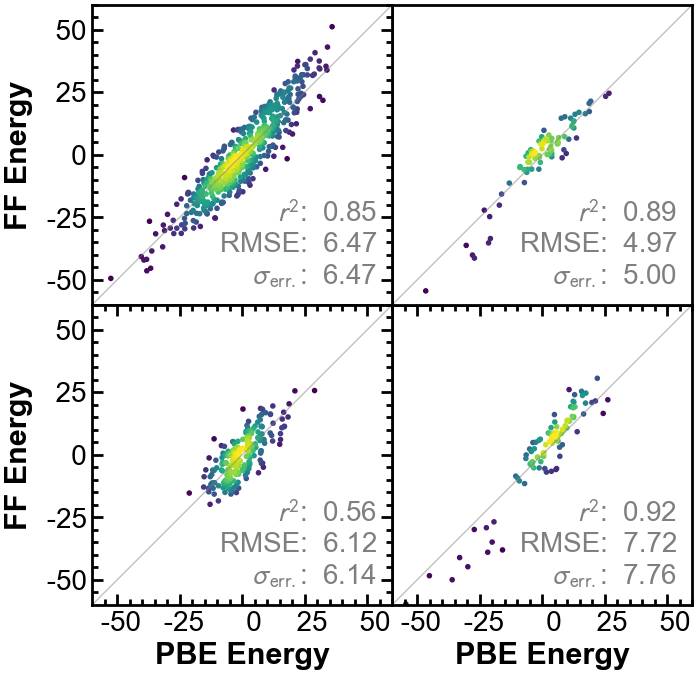

In [148]:


kplot, clplot = data_plot(data["cgenff_vs_dft"]["ions_cgenff_vs_dft"], ions=True)
waterplot = data_plot(data["cgenff_vs_dft"]["wat_cgenff_vs_dft"], ions=False)
dcmplot = data_plot(data["cgenff_vs_dft"]["ccl2_cgenff_vs_dft"], ions=False)

for _ in [waterplot , kplot, dcmplot, clplot]:
    _.set_xlabel("")
    _.set_ylabel("")
    _.set_xlim(-60,60)
    _.set_ylim(-60,60)
    _.set_xticks([-50, -25, 0, 25, 50])
    _.set_yticks([-50, -25, 0, 25, 50])
    # _.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    # _.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    
waterplot.set_xticks([])
kplot.set_xticks([])
kplot.set_yticks([])
clplot.set_yticks([])
    
row1 = pw.stack([waterplot, kplot], operator="|", margin=0.0) 
row2 = pw.stack([dcmplot, clplot], operator="|", margin=0.0) 

fig = pw.stack([row1, row2], operator="/", margin=0.0) 

CHME = "FF Energy"# [kcal/mol]"
PBE0 = "PBE Energy"# [kcal/mol]"

waterplot.set_ylabel(CHME)
dcmplot.set_ylabel(CHME)
dcmplot.set_xlabel(PBE0)
clplot.set_xlabel(PBE0)

fig.savefig("cgenff_vs_dft.pdf")


2023-10-10 10:36:02 | DEBUG | loggingTools:__exit__:357 - Took 0.000s to load font
2023-10-10 10:36:02 | DEBUG | ttFont:_readTable:459 - Reading 'maxp' table from disk
2023-10-10 10:36:02 | DEBUG | ttFont:_readTable:468 - Decompiling 'maxp' table
2023-10-10 10:36:02 | DEBUG | loggingTools:__exit__:357 - Took 0.001s to load 'maxp'
2023-10-10 10:36:02 | DEBUG | loggingTools:__exit__:357 - Took 0.000s to prune 'maxp'
2023-10-10 10:36:02 | INFO | __init__:_prune_pre_subset:3273 - maxp pruned
2023-10-10 10:36:02 | DEBUG | ttFont:_readTable:459 - Reading 'cmap' table from disk
2023-10-10 10:36:02 | DEBUG | ttFont:_readTable:468 - Decompiling 'cmap' table
2023-10-10 10:36:02 | DEBUG | ttFont:_readTable:459 - Reading 'post' table from disk
2023-10-10 10:36:02 | DEBUG | ttFont:_readTable:468 - Decompiling 'post' table
2023-10-10 10:36:02 | DEBUG | loggingTools:__exit__:357 - Took 0.005s to load 'cmap'
2023-10-10 10:36:02 | DEBUG | loggingTools:__exit__:357 - Took 0.000s to prune 'cmap'
2023-10-

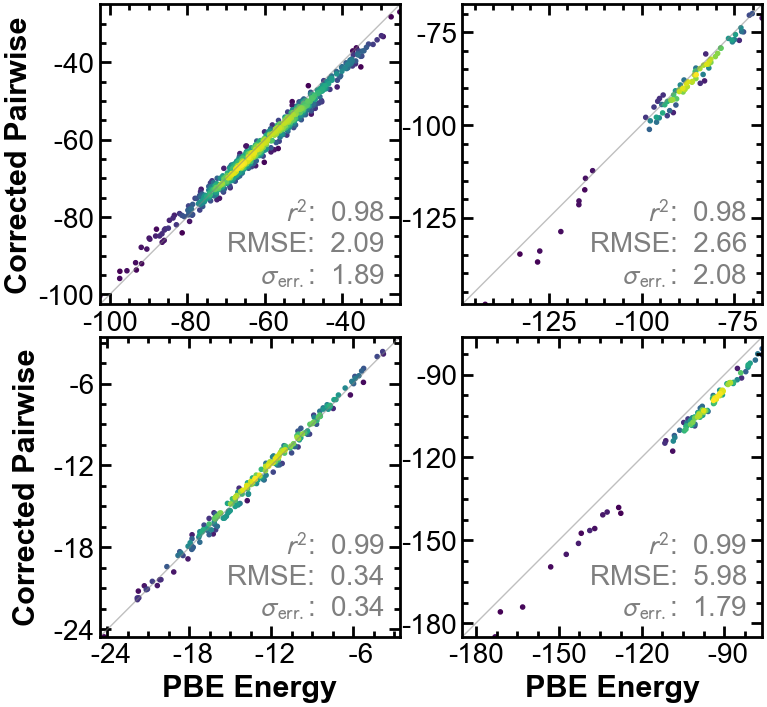

In [149]:
kplot, clplot = data_plot(data["fmo_vs_supermol"]["ions_fmo_vs_supermol"], ions=True)
waterplot = data_plot(data["fmo_vs_supermol"]["wat_fmo_vs_supermol"], ions=False)
dcmplot = data_plot(data["fmo_vs_supermol"]["ccl2_fmo_vs_supermol"], ions=False)

for _ in [waterplot , kplot, dcmplot, clplot]:
    _.set_xlabel("")
    _.set_ylabel("")
    # _.set_xlim(-190,0)
    # _.set_ylim(-190,0)
    # _.set_xticks([-50, -25, 0, 25, 50])
    
row1 = pw.stack([waterplot, kplot], operator="|", margin=0.01) 
row2 = pw.stack([dcmplot, clplot], operator="|", margin=0.01) 

fig = pw.stack([row1, row2], operator="/", margin=0.01) 

CHME = "Corrected Pairwise"#\n[kcal/mol]"
PBE0 = "PBE Energy"# [kcal/mol]"
waterplot.set_ylabel(CHME)
dcmplot.set_ylabel(CHME)
dcmplot.set_xlabel(PBE0)
clplot.set_xlabel(PBE0)

fig.savefig("FMO_vs_supermol.pdf")

2023-10-10 10:36:04 | DEBUG | loggingTools:__exit__:357 - Took 0.000s to load font
2023-10-10 10:36:04 | DEBUG | ttFont:_readTable:459 - Reading 'maxp' table from disk
2023-10-10 10:36:04 | DEBUG | ttFont:_readTable:468 - Decompiling 'maxp' table
2023-10-10 10:36:04 | DEBUG | loggingTools:__exit__:357 - Took 0.001s to load 'maxp'
2023-10-10 10:36:04 | DEBUG | loggingTools:__exit__:357 - Took 0.000s to prune 'maxp'
2023-10-10 10:36:04 | INFO | __init__:_prune_pre_subset:3273 - maxp pruned
2023-10-10 10:36:04 | DEBUG | ttFont:_readTable:459 - Reading 'cmap' table from disk
2023-10-10 10:36:04 | DEBUG | ttFont:_readTable:468 - Decompiling 'cmap' table
2023-10-10 10:36:04 | DEBUG | ttFont:_readTable:459 - Reading 'post' table from disk
2023-10-10 10:36:04 | DEBUG | ttFont:_readTable:468 - Decompiling 'post' table
2023-10-10 10:36:04 | DEBUG | loggingTools:__exit__:357 - Took 0.005s to load 'cmap'
2023-10-10 10:36:04 | DEBUG | loggingTools:__exit__:357 - Took 0.000s to prune 'cmap'
2023-10-

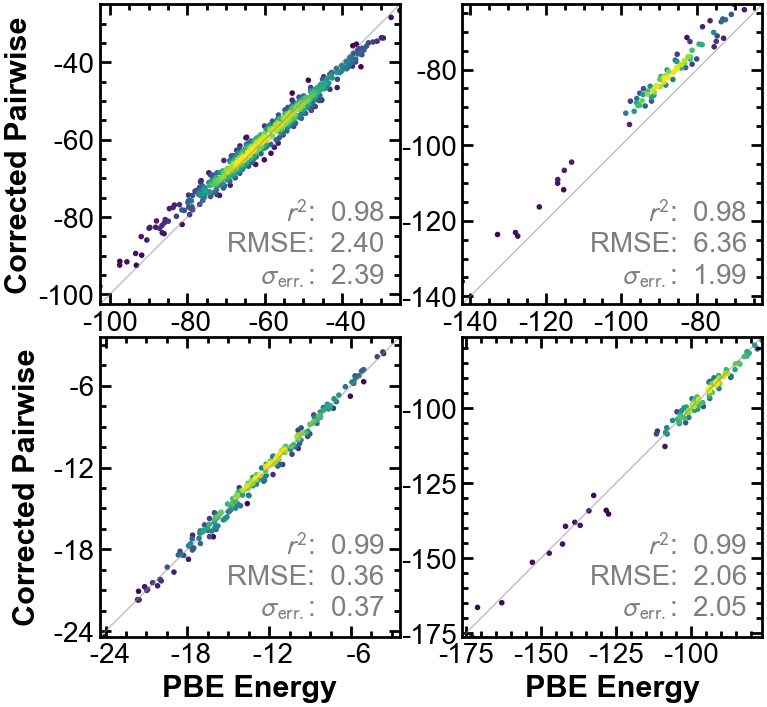

In [150]:
kplot, clplot = data_plot(data["corrected_2body"]["ions_corrected_2body"], ions=True)
waterplot = data_plot(data["corrected_2body"]["wat_corrected_2body"], ions=False)
dcmplot = data_plot(data["corrected_2body"]["ccl2_corrected_2body"], ions=False)

for _ in [waterplot , kplot, dcmplot, clplot]:
    _.set_xlabel("")
    _.set_ylabel("")
    # _.set_xlim(-190,0)
    # _.set_ylim(-190,0)
    # _.set_xticks([-50, -25, 0, 25, 50])
    
row1 = pw.stack([waterplot, kplot], operator="|", margin=0.01) 
row2 = pw.stack([dcmplot, clplot], operator="|", margin=0.01) 

fig = pw.stack([row1, row2], operator="/", margin=0.01) 

CHME = "Corrected Pairwise"#\n[kcal/mol]"
PBE0 = "PBE Energy"# [kcal/mol]"
waterplot.set_ylabel(CHME)
dcmplot.set_ylabel(CHME)
dcmplot.set_xlabel(PBE0)
clplot.set_xlabel(PBE0)

fig.savefig("corrected_2body.pdf")

2023-10-10 10:36:06 | DEBUG | loggingTools:__exit__:357 - Took 0.000s to load font
2023-10-10 10:36:06 | DEBUG | ttFont:_readTable:459 - Reading 'maxp' table from disk
2023-10-10 10:36:06 | DEBUG | ttFont:_readTable:468 - Decompiling 'maxp' table
2023-10-10 10:36:06 | DEBUG | loggingTools:__exit__:357 - Took 0.001s to load 'maxp'
2023-10-10 10:36:06 | DEBUG | loggingTools:__exit__:357 - Took 0.000s to prune 'maxp'
2023-10-10 10:36:06 | INFO | __init__:_prune_pre_subset:3273 - maxp pruned
2023-10-10 10:36:06 | DEBUG | ttFont:_readTable:459 - Reading 'cmap' table from disk
2023-10-10 10:36:06 | DEBUG | ttFont:_readTable:468 - Decompiling 'cmap' table
2023-10-10 10:36:06 | DEBUG | ttFont:_readTable:459 - Reading 'post' table from disk
2023-10-10 10:36:06 | DEBUG | ttFont:_readTable:468 - Decompiling 'post' table
2023-10-10 10:36:06 | DEBUG | loggingTools:__exit__:357 - Took 0.007s to load 'cmap'
2023-10-10 10:36:06 | DEBUG | loggingTools:__exit__:357 - Took 0.000s to prune 'cmap'
2023-10-

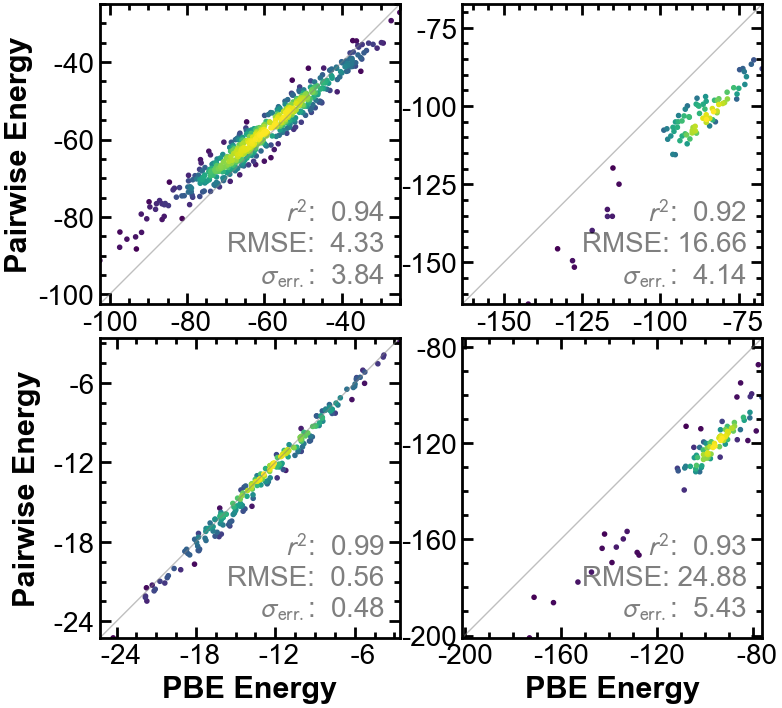

In [151]:
kplot, clplot = data_plot(data["pairwise_vs_supermol"]["ions_2body_vs_manbody"], ions=True)
waterplot = data_plot(data["pairwise_vs_supermol"]["wat_2body_vs_manybody"]*627, ions=False)
dcmplot = data_plot(data["pairwise_vs_supermol"]["ccl2_2body_vs_manbody"], ions=False)

for _ in [waterplot , kplot, dcmplot, clplot]:
    _.set_xlabel("")
    _.set_ylabel("")
    # _.set_xlim(-190,0)
    # _.set_ylim(-190,0)
    # _.set_xticks([-50, -25, 0, 25, 50])
    
row1 = pw.stack([waterplot, kplot], operator="|", margin=0.01) 
row2 = pw.stack([dcmplot, clplot], operator="|", margin=0.01) 

fig = pw.stack([row1, row2], operator="/", margin=0.01) 

CHME = "Pairwise Energy"#\n[kcal/mol]"
PBE0 = "PBE Energy"# [kcal/mol]"
waterplot.set_ylabel(CHME)
dcmplot.set_ylabel(CHME)
dcmplot.set_xlabel(PBE0)
clplot.set_xlabel(PBE0)

fig.savefig("pairwise_vs_supermol.pdf")

In [152]:
data["pairwise_vs_supermol"]["ions_2body_vs_manbody"]

,0,1,2
0,CLA_0_2,-171.110513,-184.106788
1,CLA_0_3,-138.746831,-169.674629
2,CLA_1_2,-136.946380,-163.270670
3,CLA_1_3,-173.015888,-200.977222
4,CLA_2_2,-141.833277,-157.852569
...,...,...,...
170,40_15_POT_16_1,-84.238307,-106.378075
171,40_1_POT_0_1,-88.429924,-108.676219
172,40_24_POT_26_1,-91.413867,-112.091685
173,40_29_POT_31_1,-82.994037,-101.813332


In [153]:
# data["pairwise_vs_supermol"]["wat_2body_vs_manybody"][1] = data["pairwise_vs_supermol"]["wat_2body_vs_manybody"][1] * 627

In [154]:
# data["pairwise_vs_supermol"]["wat_2body_vs_manybody"][2] = data["pairwise_vs_supermol"]["wat_2body_vs_manybody"][2] * 627

In [155]:
data["pairwise_vs_supermol"]["wat_2body_vs_manybody"]

,0,1,2
0,test0,-0.142912,-0.123471
1,test1,-0.086248,-0.085037
2,test2,-0.119472,-0.112966
3,test3,-0.096159,-0.093487
4,test4,-0.120514,-0.116926
...,...,...,...
495,test495,-0.125779,-0.115715
496,test496,-0.095644,-0.097400
497,test497,-0.094859,-0.092367
498,test498,-0.107202,-0.104336


2023-10-10 10:36:09 | DEBUG | loggingTools:__exit__:357 - Took 0.000s to load font
2023-10-10 10:36:09 | DEBUG | ttFont:_readTable:459 - Reading 'maxp' table from disk
2023-10-10 10:36:09 | DEBUG | ttFont:_readTable:468 - Decompiling 'maxp' table
2023-10-10 10:36:09 | DEBUG | loggingTools:__exit__:357 - Took 0.001s to load 'maxp'
2023-10-10 10:36:09 | DEBUG | loggingTools:__exit__:357 - Took 0.000s to prune 'maxp'
2023-10-10 10:36:09 | INFO | __init__:_prune_pre_subset:3273 - maxp pruned
2023-10-10 10:36:09 | DEBUG | ttFont:_readTable:459 - Reading 'cmap' table from disk
2023-10-10 10:36:09 | DEBUG | ttFont:_readTable:468 - Decompiling 'cmap' table
2023-10-10 10:36:09 | DEBUG | ttFont:_readTable:459 - Reading 'post' table from disk
2023-10-10 10:36:09 | DEBUG | ttFont:_readTable:468 - Decompiling 'post' table
2023-10-10 10:36:09 | DEBUG | loggingTools:__exit__:357 - Took 0.005s to load 'cmap'
2023-10-10 10:36:09 | DEBUG | loggingTools:__exit__:357 - Took 0.000s to prune 'cmap'
2023-10-

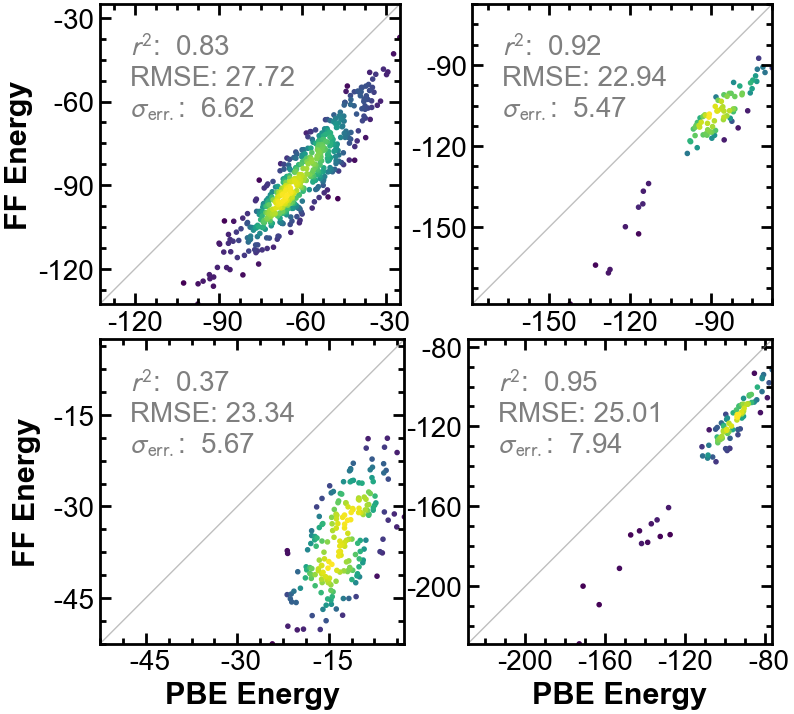

In [156]:
kplot, clplot = data_plot(data["nbonds"]["ions_cgenff_vs_dft_nbond"], ions=True, bottomLeft=False)
waterplot = data_plot(data["nbonds"]["wat_cgenff_vs_dft_nbond"], ions=False, bottomLeft=False)
dcmplot = data_plot(data["nbonds"]["ccl2_cgenff_vs_dft_nbond"], ions=False, bottomLeft=False)

for _ in [waterplot , kplot, dcmplot, clplot]:
    _.set_xlabel("")
    _.set_ylabel("")
    # _.set_xlim(-190,0)
    # _.set_ylim(-190,0)
    # _.set_xticks([-50, -25, 0, 25, 50])
    
row1 = pw.stack([waterplot, kplot], operator="|", margin=0.01) 
row2 = pw.stack([dcmplot, clplot], operator="|", margin=0.01) 

fig = pw.stack([row1, row2], operator="/", margin=0.01) 

CHME = "FF Energy"#\n[kcal/mol]"
PBE0 = "PBE Energy"# [kcal/mol]"
waterplot.set_ylabel(CHME)
dcmplot.set_ylabel(CHME)
dcmplot.set_xlabel(PBE0)
clplot.set_xlabel(PBE0)

fig.savefig("nbonds.pdf")

In [157]:
# data["manybody_vs_epol"]

0 ('C', 'C')
1 ('C', 'CG331')
2 ('C', 'CL')
3 ('C', 'CLA')
4 ('C', 'H')
5 ('C', 'HGA3')
6 ('C', 'HGP1')
7 ('C', 'HT')
8 ('C', 'OG311')
9 ('C', 'OT')
10 ('C', 'POT')
11 ('CG331', 'CG331')
12 ('CG331', 'CL')
13 ('CG331', 'CLA')
14 ('CG331', 'H')
15 ('CG331', 'HGA3')
16 ('CG331', 'HGP1')
17 ('CG331', 'HT')
18 ('CG331', 'OG311')
19 ('CG331', 'OT')
20 ('CG331', 'POT')
21 ('CL', 'CL')
22 ('CL', 'CLA')
23 ('CL', 'H')
24 ('CL', 'HGA3')
25 ('CL', 'HGP1')
26 ('CL', 'HT')
27 ('CL', 'OG311')
28 ('CL', 'OT')
29 ('CL', 'POT')
30 ('CLA', 'CLA')
31 ('CLA', 'H')
32 ('CLA', 'HGA3')
33 ('CLA', 'HGP1')
34 ('CLA', 'HT')
35 ('CLA', 'OG311')
36 ('CLA', 'OT')
37 ('CLA', 'POT')
38 ('H', 'H')
39 ('H', 'HGA3')
40 ('H', 'HGP1')
41 ('H', 'HT')
42 ('H', 'OG311')
43 ('H', 'OT')
44 ('H', 'POT')
45 ('HGA3', 'HGA3')
46 ('HGA3', 'HGP1')
47 ('HGA3', 'HT')
48 ('HGA3', 'OG311')
49 ('HGA3', 'OT')
50 ('HGA3', 'POT')
51 ('HGP1', 'HGP1')
52 ('HGP1', 'HT')
53 ('HGP1', 'OG311')
54 ('HGP1', 'OT')
55 ('HGP1', 'POT')
56 ('HT', 'HT'

2023-10-26 10:29:46 | DEBUG | loggingTools:__exit__:357 - Took 0.001s to load font
2023-10-26 10:29:46 | DEBUG | ttFont:_readTable:459 - Reading 'maxp' table from disk
2023-10-26 10:29:46 | DEBUG | ttFont:_readTable:468 - Decompiling 'maxp' table
2023-10-26 10:29:46 | DEBUG | loggingTools:__exit__:357 - Took 0.001s to load 'maxp'
2023-10-26 10:29:46 | DEBUG | loggingTools:__exit__:357 - Took 0.000s to prune 'maxp'
2023-10-26 10:29:46 | INFO | __init__:_prune_pre_subset:3273 - maxp pruned
2023-10-26 10:29:46 | DEBUG | ttFont:_readTable:459 - Reading 'cmap' table from disk
2023-10-26 10:29:46 | DEBUG | ttFont:_readTable:468 - Decompiling 'cmap' table
2023-10-26 10:29:46 | DEBUG | ttFont:_readTable:459 - Reading 'post' table from disk
2023-10-26 10:29:46 | DEBUG | ttFont:_readTable:468 - Decompiling 'post' table
2023-10-26 10:29:46 | DEBUG | loggingTools:__exit__:357 - Took 0.014s to load 'cmap'
2023-10-26 10:29:46 | DEBUG | loggingTools:__exit__:357 - Took 0.000s to prune 'cmap'
2023-10-

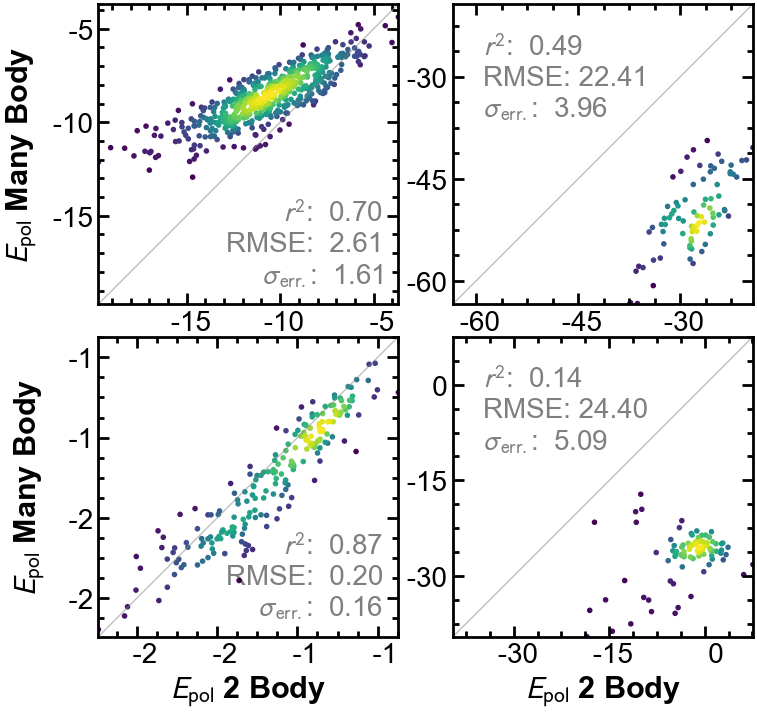

In [163]:
# dict_keys(['cgenff_vs_dft', 'fmo_vs_supermol', 'manybody_vs_epol', 'corrected_2body', 'fig4', 'pairwise_vs_supermol', 'nbonds'])
kplot, clplot = data_plot(
    data["manybody_vs_epol"]["k_ions_epol_mbody_vs_epol_2body"], ions=False, bottomLeft=False), data_plot(
    data["manybody_vs_epol"]["cl_ions_epol_mbody_vs_epol_2body"], ions=False, bottomLeft=False)
waterplot = data_plot(data["manybody_vs_epol"]["water_epol_mbody_vs_epol_2body"], ions=False)
dcmplot = data_plot(data["manybody_vs_epol"]["ch2cl2_epol_mbody_vs_epol_2body"], ions=False)

for _ in [waterplot , kplot, dcmplot, clplot]:
    _.set_xlabel("")
    _.set_ylabel("")
    # _.set_xlim(-190,0)
    # _.set_ylim(-190,0)
    # _.set_xticks([-50, -25, 0, 25, 50])
    
row1 = pw.stack([waterplot, kplot], operator="|", margin=0.01) 
row2 = pw.stack([dcmplot, clplot], operator="|", margin=0.01) 

fig = pw.stack([row1, row2], operator="/", margin=0.01) 

CHME = "$E_{\mathrm{pol}}$ Many Body"#\n[kcal/mol]"
PBE0 = "$E_{\mathrm{pol}}$ 2 Body"# [kcal/mol]"

waterplot.set_ylabel(CHME)
dcmplot.set_ylabel(CHME)
dcmplot.set_xlabel(PBE0)
clplot.set_xlabel(PBE0)

fig.savefig("manybody_vs_epol.pdf")

In [159]:
# kplot.__dict__

In [167]:
axes = []
titles = []
for i, (k,v) in enumerate(data["fig4"].items()):
    # print(k,v)
    _ = data_plot(v)
    xlabel = "PBE Energy"
    ylabel = "PBE Energy"
    kspl = k.split("_")
    remove = ["Eint", "PBE0"]
    print(kspl)
    ksrem = [_ for _ in kspl if _ not in remove]
    # title = " ".join(ksrem)
    # _.set_title(title)
    xl = "PBE0 Energy " 
    yl = "PBE0 Energy " 
    if ksrem[-1] == "vs":
        yl += "\n({})".format(" ".join(ksrem[:-1]))
    elif ksrem[0] == "vs":
        xl += "\n({})".format(" ".join(ksrem[1:]))
    else:
        j = "_".join(ksrem)
        x_, y_ = j.split("vs")
        x_ = x_.split("_")
        y_ = y_.split("_")
        xl += "\n({})".format(" ".join(x_)[:-1])
        yl += "\n({})".format(" ".join(y_)[1:])
               
    _.set_xlabel(xl)
    _.set_ylabel(yl)
    
    if i == 2:
        _.set_ylabel("PBE0 Energy\n(BSSE corr)")
    
    axes.append(_)
    


['Eint', 'PBE0', 'BSSE', 'corr', 'vs', 'Eint', 'PBE0']
['Eint', 'PBE0', 'BSSE', 'corr', 'vs', 'Eint', 'pairwise', 'PBE0', 'BSSE', 'corr']
['Eint', 'PBE0', 'vs', 'Eint', 'pairwise', 'PBE0']
['Eint', 'pairwise', 'PBE0', 'BSSE', 'corr', 'vs', 'Eint', 'pairwise', 'PBE0']


In [199]:
BSSEfigs = pw.stack(axes)

2023-10-26 16:57:09 | DEBUG | loggingTools:__exit__:357 - Took 0.000s to load font
2023-10-26 16:57:09 | DEBUG | ttFont:_readTable:459 - Reading 'maxp' table from disk
2023-10-26 16:57:09 | DEBUG | ttFont:_readTable:468 - Decompiling 'maxp' table
2023-10-26 16:57:09 | DEBUG | loggingTools:__exit__:357 - Took 0.001s to load 'maxp'
2023-10-26 16:57:09 | DEBUG | loggingTools:__exit__:357 - Took 0.000s to prune 'maxp'
2023-10-26 16:57:09 | INFO | __init__:_prune_pre_subset:3273 - maxp pruned
2023-10-26 16:57:09 | DEBUG | ttFont:_readTable:459 - Reading 'cmap' table from disk
2023-10-26 16:57:09 | DEBUG | ttFont:_readTable:468 - Decompiling 'cmap' table
2023-10-26 16:57:09 | DEBUG | ttFont:_readTable:459 - Reading 'post' table from disk
2023-10-26 16:57:09 | DEBUG | ttFont:_readTable:468 - Decompiling 'post' table
2023-10-26 16:57:09 | DEBUG | loggingTools:__exit__:357 - Took 0.007s to load 'cmap'
2023-10-26 16:57:09 | DEBUG | loggingTools:__exit__:357 - Took 0.000s to prune 'cmap'
2023-10-

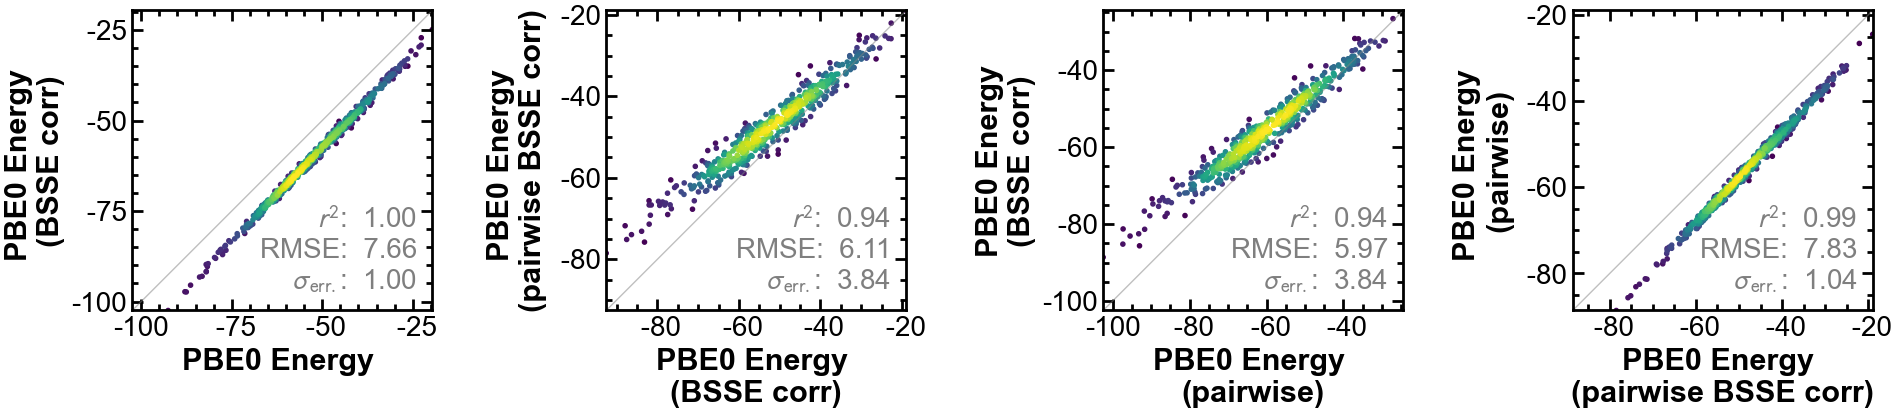

In [200]:
BSSEfigs.savefig("BSSE_water.pdf")

In [196]:
# dict_keys(['cgenff_vs_dft', 'fmo_vs_supermol', 'manybody_vs_epol', 'corrected_2body', 'fig4', 'pairwise_vs_supermol', 'nbonds'])
kplot, clplot = data_plot(
    data["manybody_pairwise_coulomb"]["2body_vs_many_ions"], ions=True, bottomLeft=False)
waterplot = data_plot(data["manybody_pairwise_coulomb"]["2body_vs_many_h2o"], ions=False)
dcmplot = data_plot(data["manybody_pairwise_coulomb"]["2body_vs_many_ccl2"], ions=False)

for _ in [waterplot , kplot, dcmplot, clplot]:
    _.set_xlabel("")
    _.set_ylabel("")
    # _.set_xlim(-190,0)
    # _.set_ylim(-190,0)
    # _.set_xticks([-50, -25, 0, 25, 50])
    
row1 = pw.stack([waterplot, kplot], operator="|", margin=0.01) 
row2 = pw.stack([dcmplot, clplot], operator="|", margin=0.01) 

fig = pw.stack([row1, row2], operator="/", margin=0.01) 

CHME = "$E_{\mathrm{CI}}$ 2 Body"#\n[kcal/mol]"
PBE0 = "$E_{\mathrm{CI}}$ Many Body"# [kcal/mol]"

waterplot.set_ylabel(CHME)
dcmplot.set_ylabel(CHME)
dcmplot.set_xlabel(PBE0)
clplot.set_xlabel(PBE0)



Text(0.5, -369.6666666666667, '$E_{\\mathrm{CI}}$ Many Body')

2023-10-26 16:55:28 | DEBUG | loggingTools:__exit__:357 - Took 0.000s to load font
2023-10-26 16:55:28 | DEBUG | ttFont:_readTable:459 - Reading 'maxp' table from disk
2023-10-26 16:55:28 | DEBUG | ttFont:_readTable:468 - Decompiling 'maxp' table
2023-10-26 16:55:28 | DEBUG | loggingTools:__exit__:357 - Took 0.001s to load 'maxp'
2023-10-26 16:55:28 | DEBUG | loggingTools:__exit__:357 - Took 0.000s to prune 'maxp'
2023-10-26 16:55:28 | INFO | __init__:_prune_pre_subset:3273 - maxp pruned
2023-10-26 16:55:28 | DEBUG | ttFont:_readTable:459 - Reading 'cmap' table from disk
2023-10-26 16:55:28 | DEBUG | ttFont:_readTable:468 - Decompiling 'cmap' table
2023-10-26 16:55:28 | DEBUG | ttFont:_readTable:459 - Reading 'post' table from disk
2023-10-26 16:55:28 | DEBUG | ttFont:_readTable:468 - Decompiling 'post' table
2023-10-26 16:55:28 | DEBUG | loggingTools:__exit__:357 - Took 0.006s to load 'cmap'
2023-10-26 16:55:28 | DEBUG | loggingTools:__exit__:357 - Took 0.000s to prune 'cmap'
2023-10-

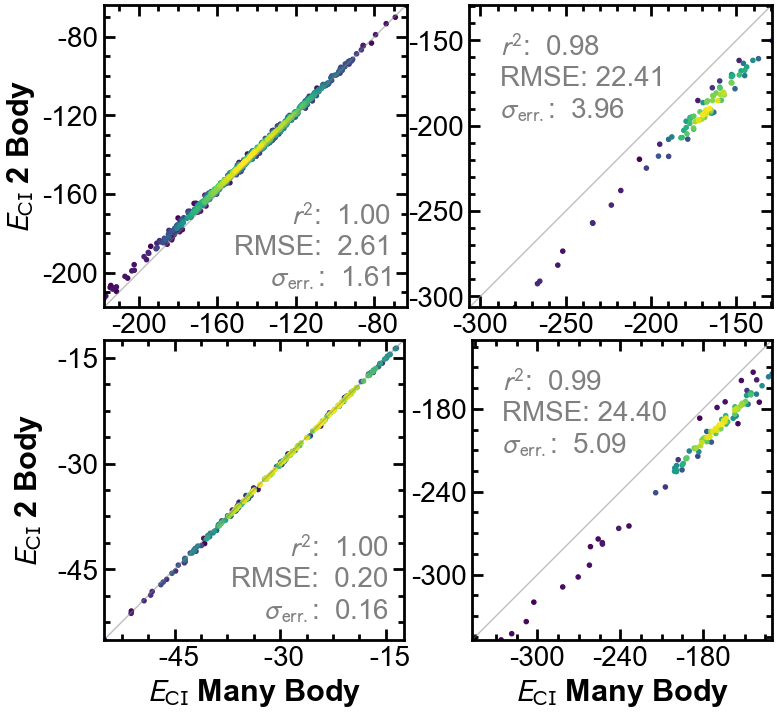

In [198]:
fig.savefig("manybody_vs_pairwise_ci.pdf")

In [188]:
data["manybody_pairwise_coulomb"]["2body_vs_many_ions"
                                 ][0] = data["manybody_pairwise_coulomb"
                                            ]["2body_vs_many_ions"][1]
data["manybody_pairwise_coulomb"]["2body_vs_many_ions"
                                 ][1] = data["manybody_pairwise_coulomb"
                                            ]["2body_vs_many_ions"][2]
data["manybody_pairwise_coulomb"]["2body_vs_many_ions"
                                 ][2] = data["manybody_pairwise_coulomb"
                                            ]["2body_vs_many_ions"][3]

In [193]:
# data["manybody_pairwise_coulomb"]["2body_vs_many_h2o"
#                                  ][0] = data["manybody_pairwise_coulomb"
#                                             ]["2body_vs_many_h2o"][1]
# data["manybody_pairwise_coulomb"]["2body_vs_many_h2o"
#                                  ][1] = data["manybody_pairwise_coulomb"
#                                             ]["2body_vs_many_h2o"][2]
# data["manybody_pairwise_coulomb"]["2body_vs_many_h2o"
#                                  ][2] = data["manybody_pairwise_coulomb"
#                                             ]["2body_vs_many_h2o"][3]

In [187]:
data["manybody_pairwise_coulomb"]["2body_vs_many_h2o"
                                 ]

,0,1,2
0,0,-189.398308,-183.762704
1,1,-112.670681,-111.698932
2,2,-156.224798,-153.157230
3,3,-115.255070,-112.698517
4,4,-152.162099,-150.091466
...,...,...,...
495,495,-169.618808,-166.163994
496,496,-136.225511,-134.761811
497,497,-173.189401,-170.915779
498,498,-166.451281,-164.076293


In [191]:
data["manybody_pairwise_coulomb"]["2body_vs_many_ccl2"
                                 ][0] = data["manybody_pairwise_coulomb"
                                            ]["2body_vs_many_ccl2"][1]
data["manybody_pairwise_coulomb"]["2body_vs_many_ccl2"
                                 ][1] = data["manybody_pairwise_coulomb"
                                            ]["2body_vs_many_ccl2"][2]
data["manybody_pairwise_coulomb"]["2body_vs_many_ccl2"
                                 ][2] = data["manybody_pairwise_coulomb"
                                            ]["2body_vs_many_ccl2"][3]

In [192]:
data["manybody_pairwise_coulomb"]["2body_vs_many_ccl2"
                                 ]

,0,1,2,3,target,vals
0,100_4322_DCM_499_988,-25.394893,-25.395131,-25.395131,100_4322_DCM_499_988,-25.394893
1,100_646_DCM_76_1117,-48.384520,-48.673826,-48.673826,100_646_DCM_76_1117,-48.384520
2,100_1774_DCM_207_229,-23.829182,-24.024399,-24.024399,100_1774_DCM_207_229,-23.829182
3,100_2990_DCM_349_1039,-27.026714,-27.066393,-27.066393,100_2990_DCM_349_1039,-27.026714
4,100_392_DCM_46_962,-18.158171,-18.294847,-18.294847,100_392_DCM_46_962,-18.158171
...,...,...,...,...,...,...
196,100_1849_DCM_216_299,-27.579926,-27.633479,-27.633479,100_1849_DCM_216_299,-27.579926
197,100_78_DCM_9_1170,-28.538477,-28.768151,-28.768151,100_78_DCM_9_1170,-28.538477
198,100_410_DCM_48_226,-23.982206,-24.146258,-24.146258,100_410_DCM_48_226,-23.982206
199,100_1237_DCM_145_421,-22.985083,-22.786450,-22.786450,100_1237_DCM_145_421,-22.985083
